<a href="https://colab.research.google.com/github/andreggalvao/Bootcamp_Arq_ML_XPE_2023_3A/blob/main/Semana%201/Desafio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Importações padrões
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importando ferramentas
from sklearn.model_selection import KFold, RandomizedSearchCV

# Importações de classe Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet152
from keras.preprocessing import image
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Importando outras bibliotecas necessárias
import tensorflow as tf
from tensorflow.image import resize
import cv2
import zipfile
import os
import requests

In [3]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
# Informando onde as imagens estão armazenadas

train_cats_dir = 'https://github.com/andreggalvao/Bootcamp_Arq_ML_XPE_2023_3A/tree/main/Semana%201/cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'https://github.com/andreggalvao/Bootcamp_Arq_ML_XPE_2023_3A/tree/main/Semana%201/cats_and_dogs_filtered/train/dogs'

validation_cats_dir = 'https://github.com/andreggalvao/Bootcamp_Arq_ML_XPE_2023_3A/tree/main/Semana%201/cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'https://github.com/andreggalvao/Bootcamp_Arq_ML_XPE_2023_3A/tree/main/Semana%201/cats_and_dogs_filtered/validation/dogs'





In [25]:
# Baixando imagem
!wget --no-check-certificate \
 https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
 -O /tmp/cats_and_dogs_filtered.zip

# Abrindo e extraindo o zip
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Definindo os diretórios
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Endereço dos diretórios finais
train_cats_dir = os.path.join(train_dir, 'cats') # Diretório com imagens de treinamentos de gatos
train_dogs_dir = os.path.join(train_dir, 'dogs') # Diretório com imagens de treinamentos de cacho
validation_cats_dir = os.path.join(validation_dir, 'cats') # Diretório com imagens de teste de gatos
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # Diretório com imagens de teste de cach

--2023-03-24 14:49:12--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   147MB/s    in 0.4s    

2023-03-24 14:49:12 (147 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
train_cats_dir

In [29]:

images = []
labels = []

dir_paths =[train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir ]

# diretório onde as imagens estão armazenadas
dir_path = train_cats_dir

# leia cada imagem no diretório e adicione-a na lista de imagens
for img_name in os.listdir(dir_path):
    # verifique se o arquivo é uma imagem
    if img_name.endswith('.jpg'):
        img_path = os.path.join(dir_path, img_name)
        img = cv2.imread(img_path)
        images.append(img)
        labels.append('gato')


In [ ]:
os.listdir(train_cats_dir)

# Vamos agora tratar os códigos para usar no novo modelo.

Com os dados já limpos vamos realizar o desenvolvimento de um modelo base: 
1. Carregando os dados e preparação dos dados
3. Definindo o modelo
4. Medindo o modelo
5. Apresentação de resultados

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


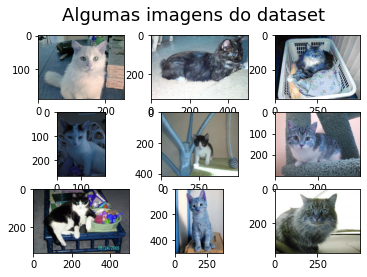

In [32]:

# #Vendo as imagens
plt.suptitle("Algumas imagens do dataset", fontsize = 18)
c = 1
for i in range(9):
 plt.subplot(3, 3, c)
 plt.imshow(images[i], cmap='gray')
 c = c + 1
plt.show()

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

# Trabalhando com o VGG

## Que mudanças temos que nos preocupar?

1. Alterar a dimensão da entrada da rede: A VGG16 inicialmente foi treinada para imagens coloridas. Portanto, é necessário que ela receba imagens com canais de cor. Ou seja, cada pixel da imagem será representado por mais de um valor. Tipicamente, utilizamos o sistema de cor RGB, ou seja, cada pixel da imagem é composto por três valores. Podemos dizer, portanto, que uma imagem de 32 pixels de largura e 32 pixels de altura no sistema RGB tem uma dimensionalidade de 32x32x3. Como as imagens do Fashion MNIST são em tons de cinza (ou seja, só possuem um canal de cor e, portanto, cada imagem tem o tamanho 28x28x1), é necessário redimensionar as imagens do dataset para 32x32x3, adicionando outros dois canais para usar o VGG16;


2. Alterar a camada de saída: A camada de saída da VGG16 original tem 1000 neurônios, que correspondem ao número de classes no conjunto de dados ImageNet. Para o Fashion MNIST, é necessário alterar o número de neurônios na camada de saída para 10, que é o número de classes no conjunto de dados. Portanto, é necessário substituir a camada de saída da VGG16 por uma nova camada densa com 10 neurônios e uma camada de ativação softmax para classificação;

3. Ajustar a taxa de aprendizagem do otimizador: Como o Fashion MNIST é um conjunto de dados mais simples em comparação com o ImageNet, pode ser necessário ajustar a taxa de aprendizagem do otimizador para um valor mais baixo, a fim de evitar overfitting.

In [ ]:
import cv2
import numpy as np
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau





In [ ]:
def carregamento_dados():
  
# Define o número de classes do conjunto de dados
  num_classes = 10

# Carrega o conjunto de dados Fashion MNIST
  (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Redimensiona as imagens para o tamanho de entrada da VGG16 (32x32x3)
  X_train = np.array([cv2.resize(img, (32, 32)) for img in X_train])
  X_test = np.array([cv2.resize(img, (32, 32)) for img in X_test])

# Adiciona um canal para as imagens em escala de cinza (3ª dimensão)
  X_train = np.stack((X_train,) * 3, axis=-1)
  X_test = np.stack((X_test,) * 3, axis=-1)

# Normaliza as imagens
  X_train = X_train.astype('float32') / 255
  X_test = X_test.astype('float32') / 255

# Converte os rótulos para o formato de one-hot encoding
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)


  return X_train, y_train, X_test, y_test

In [ ]:
def modelo_compile():
# Carrega o modelo VGG16 sem a camada de saída
  base_model = VGG16(weights = None, include_top = False, input_shape = (32, 32, 3))

# Adiciona camadas densas personalizadas na parte superior do modelo
  modelo = Sequential()
  modelo.add(base_model)
  modelo.add(Flatten())
  modelo.add(Dense(256, activation = 'relu'))
  modelo.add(Dropout(0.5))
  modelo.add(Dense(10, activation = 'softmax'))

# Define o otimizador Adam com taxa de aprendizado reduzida
  optimizer = Adam(learning_rate=0.0002) # Original é 0.0001

# Compila o modelo
  modelo.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  return modelo

In [ ]:
def modelo_fit(modelo, X_train, y_train, X_test, y_test):

# Configurando callbacks
  earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 0, mode = 'min') # Monitora as épocas e para caso não esteja melhorando
  mcp_save = ModelCheckpoint('best_weights.hdf5', save_best_only = True, monitor = 'val_loss', mode = 'min') # Salvando a melhor configuração
  reduce_lr_loss = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4, patience = 7, verbose = 1, min_delta = 1e-4, mode = 'auto') # Reduz o learning_rate quando a métrica de avaliação para de melhorar

# Treina o modelo
  history = modelo.fit(X_train, y_train, batch_size = 32, epochs = 30, validation_data = (X_test, y_test), callbacks = [earlyStopping, mcp_save, reduce_lr_loss])

  # Avaliando modelo
  _, acc = modelo.evaluate(X_test, y_test, verbose = 0)
  print('Acurácia final = %.3f' % (acc * 100.0))

# Salvando as métricas
  scores = acc
  historico = history

  return scores, historico

In [ ]:
## Rodando tudo de uma vez

def rodando_tudo():
  
	# carregando os dados
	X_train, y_train, X_test, y_test = carregamento_dados()
 
	# Compilação do modelo base
	modelo = modelo_compile()
 
	# fit com configurações pre-estabelecidas
	scores, historico = modelo_fit(modelo, X_train, y_train, X_test, y_test)
 
	

In [ ]:
rodando_tudo()

Epoch 1/30
1875/1875 [==============================] - 64s 28ms/step - loss: 0.6385 - accuracy: 0.7650 - val_loss: 0.3747 - val_accuracy: 0.8667 - lr: 2.0000e-04
Epoch 2/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.3296 - accuracy: 0.8854 - val_loss: 0.2665 - val_accuracy: 0.9002 - lr: 2.0000e-04
Epoch 3/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2682 - accuracy: 0.9058 - val_loss: 0.2704 - val_accuracy: 0.9033 - lr: 2.0000e-04
Epoch 4/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2304 - accuracy: 0.9206 - val_loss: 0.2681 - val_accuracy: 0.9102 - lr: 2.0000e-04
Epoch 5/30
1875/1875 [==============================] - 53s 28ms/step - loss: 0.2058 - accuracy: 0.9289 - val_loss: 0.2382 - val_accuracy: 0.9149 - lr: 2.0000e-04
Epoch 6/30
1875/1875 [==============================] - 52s 28ms/step - loss: 0.1798 - accuracy: 0.9375 - val_loss: 0.2487 - val_accuracy: 0.9148 - lr: 2.0000e-04
Epoch 7/30
1875/1875 [